# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [4]:
DATA_FOLDER = '../../ADA2017-Tutorials/02 - Intro to Pandas/Data/' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

On commence par analyser la stucture des fichiers : 

In [3]:
!cat '../../ADA2017-Tutorials/02 - Intro to Pandas/Data/ebola/guinea_data/2014-09-11.csv' | head -n 2 
! echo "\n"
!cat '../../ADA2017-Tutorials/02 - Intro to Pandas/Data/ebola/liberia_data/2014-09-17-v125.csv' | head -n 2
! echo "\n"
!cat '../../ADA2017-Tutorials/02 - Intro to Pandas/Data/ebola/sl_data/2014-08-18-v83.csv' | head -n 2
! echo "\n"

Date,Description,Totals,Conakry,Gueckedou,Macenta,Dabola,Kissidougou,Dinguiraye,Telimele,Boffa,Kouroussa,Siguiri,Pita,Mzerekore,Yomou,Dubreka,Forecariah,Kerouane,Coyah,Dalaba,Beyla,Kindia,Lola
2014-09-11,New cases of suspects,9,,4,1,,,,,,,,,,,,1,3,,,,,


Date,Variable,National,Bomi County,Bong County,Gbarpolu County,Grand Bassa,Grand Cape Mount,Grand Gedeh,Grand Kru,Lofa County,Margibi County,Maryland County,Montserrado County,Nimba County,River Gee County,RiverCess County,Sinoe County
9/17/2014,Specimens collected,,,,,,,,,,,,,,,,


date,variable,Kailahun,Kenema,Kono,Kambia,Koinadugu,Bombali,Tonkolili,Port Loko,Pujehun,Bo,Moyamba,Bonthe,Western area urban,Western area rural,National
2014-08-18,population,"465,048","653,013","325,003","341,690","335,471","494,139","434,937","557,978","335,574","654,142","278,119","168,729","1,040,888","263,619","6,348,350"




Premiere dificulter chaque pays à sont propre format mais Gloabalement similaire :
Date , Description/Variable , Toatal/National , les donner pour chaque region ou county

On peut voir ce que contien le champs variable/Description comme valeur avec la comande :

`cat ../../ADA2017-Tutorials/02-\ Intro\ to\ Pandas/Data/ebola/*/* |  cut -d, -f2  | sort | uniq`

Globalement on a des indication sur le nombre de mort et contaminer.
On vois que beacoup de champs on des nom différent pour de meme indication comme par exepmle : new deaths registered et new deaths registered today.

L'objectif etant d'avoir le nombre de nouveau cas et de mort par jour il faudra addisioner ces champs pour obetenir le nombre totale de nouveau cas ou de mort.

On vas donc mettre le nombre de nouveau cas et de mort comme nom de colone pour avoir un tableau qui resemble a ça :

Date,Pays,Regions, New case, death ...

Ce qui sera plus facile pour obetenir des statistique par pays.

Or nous avons vue les que donner sont dans un format "transposer" , il falloir donc transposer chaque fichier pour les mettre dans le format qui nous intérésse.


In [538]:
import glob

data = pd.DataFrame() # creation d'une table vide

# indique le nombre maximum de fichier a chargé : permet d'accéler le script pour debug
max_file = 10000
max_file_i = 0
# pour chaque fichier de chaque répertoire
for csv in  glob.glob(DATA_FOLDER+"ebola/*/*.csv"): 
    
    # on lit le csv et on, rajoute - comme valeur manquante car - apparait parfois
    subframe =  pd.read_csv(csv,na_values="-")
    
    # on convertti tout les nom en minuscule pour avoir des nom normaliser
    subframe.columns = [x.lower() for x in subframe.columns]
    
        
    # on renome description pour avoir le meéne nom de colone pour chaques pays
    if(subframe.columns[1]=="description") : 
        subframe.rename(columns={'description': 'variable'}, inplace=True)

    # on récupére la date et on la convertit dans le formas de panda, la date unique dans chaque fichier
    assert len(subframe['date'].drop_duplicates()) == 1
    uniquedate = pd.to_datetime(subframe['date'][0])
    # et on suprimme la colone date
    subframe.drop('date',axis=1, inplace=True)
    #on place en index les description des donner, lors de la traposer les description deviendron le nom des colone
    subframe = subframe.set_index("variable")
    #on Transpose , ici maintenat on a un Data frame dont les donner sont les région et les colone les descriptions
    subframe = subframe.transpose()
    # on convertir tout les nouveau nom en minuscule pour ne pas avoir de probléme de comparaison
    subframe.columns = [x.lower() for x in subframe.columns]
    
    # on s'assure que toute non donner soient biens intéerpere comme nomnbre
    subframe = subframe.apply(pd.to_numeric,errors='ignore')
    
    #puis on rajoute la date
    subframe['date'] = uniquedate

    #et le pays
    if "guinea" in csv :
        subframe['country'] = "Guinea"
    if "liberia" in csv :
        subframe['country'] = "Liberia"
    if "sl" in csv :
        subframe['country'] = "Siera Leon"
        
    # lors de la transposer les nom des regtion sont de venue des index, on reset l'endex afin que les regtion devien un champs normale
    subframe.reset_index(level=0, inplace=True)  
    # et on attribut le nom regions au champs contenant les regions
    subframe.rename(columns={'index': 'regions'}, inplace=True)

    # on surpimme les colone qui sont dupliquer : la description pending est parfois en plusier exemplaire    
    subframe = subframe.loc[:,~subframe.columns.duplicated()]

    # ici on plance les donner date,country, et regions en premier 
    cols = ['date','country','regions']  + [col for col in subframe if (col != 'date' and col != 'country' and col != 'regions') ]
    subframe = subframe[cols]
    
        
    # puis on ajoute les donner au précédant DataFrame
    if(len(data)==0):
        data = subframe
    else :
  
        data = pd.concat([data,subframe], axis=0, ignore_index=True)
        # concat change l'odre des colone , on le remet dans l'odre de lecture
        cols = ['date','country','regions']  + [col for col in data if (col != 'date' and col != 'country' and col != 'regions') ]
        data = data[cols]
       
    # on stop si on a attent le nombre de fichier max
    if(max_file_i>max_file):
           break
    max_file_i = max_file_i+1

# il reste plus que a fussioner(addiosner) les colone qui on le méme sense  

data.shape

(3588, 144)

Maintenant on rasemble le nombre de mort par jour et et nouveau contaminer.
Ici on compte les cas suspec ,confirmer et probable.Mais c'est un choix arbitraire car l'enoncer ne présise pas quois faire.

In [110]:

data['total_new_death'] = data['new deaths registered'].fillna(0)+data['new deaths registered today'].fillna(0)+data['newly reported deaths'].fillna(0)+data['etc_new_deaths'].fillna(0)

data['total_newcase'] = data["total new cases registered so far"].fillna(0)+ data['new case/s (confirmed)'].fillna(0) + data['new case/s (probable)'].fillna(0) + data['new case/s (suspected)'].fillna(0) + data['new_confirmed'].fillna(0) + data['new_probable'].fillna(0) + data['new_suspected'].fillna(0); 


In [ ]:
Puis on calcul la moyenne par pays et par mois

In [111]:
gb_data = data[data['regions'].isin(["national" ,"totals"])].set_index("date").groupby(['country',pd.TimeGrouper(freq='M')])
gb_data['total_newcase'].mean()

country     date      
Guinea      2014-08-31      25.800000
            2014-09-30      19.625000
            2014-10-31      34.000000
Liberia     2014-06-30       5.714286
            2014-07-31       8.545455
            2014-08-31      37.222222
            2014-09-30      63.833333
            2014-10-31      45.560000
            2014-11-30      26.466667
            2014-12-31    5178.555556
Siera Leon  2014-08-31      25.150000
            2014-09-30      40.689655
            2014-10-31      70.928571
            2014-11-30      75.238095
            2014-12-31      41.000000
Name: total_newcase, dtype: float64

In [112]:
gb_data['total_new_death'].mean()


country     date      
Guinea      2014-08-31     3.400000
            2014-09-30     3.562500
            2014-10-31    15.000000
Liberia     2014-06-30     2.000000
            2014-07-31     4.272727
            2014-08-31    23.222222
            2014-09-30    36.041667
            2014-10-31    28.040000
            2014-11-30    13.466667
            2014-12-31     0.000000
Siera Leon  2014-08-31     0.000000
            2014-09-30     0.275862
            2014-10-31     3.535714
            2014-11-30     0.571429
            2014-12-31     2.200000
Name: total_new_death, dtype: float64

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

Here, each xml file have a bacterie name and a value.The name of file is he same as the name in the metadata.xml 

To begin , we merge xml file with bacterie name for key, after we rename collumn with name in metadata. 

In [6]:
import glob
from os.path import basename
import os 

data = pd.DataFrame(columns =['name']) 

# For each  MID files
for excel in  glob.glob(DATA_FOLDER+"microbiome/*.xls"): 
    if "meta" not in excel : 
        #get name of file/name of collumn of data
        mid =os.path.splitext(basename(excel))[0]
        # read without header
        subdata  = pd.read_excel(excel,header=None)
        # rename data with mid name
        subdata.columns = ["name",mid]
        # Test if bacteril name is unique, for integirty 
        assert ( any(subdata['name'].duplicated()) == False)
        # we merge the Dataframe with the name for common key, "outer" add the new bacterie
        data = data.merge(subdata,on='name', how='outer')
        # change na by unknowd
        data.fillna("unknows", inplace = True)
        

# set name to index, do no crash , name are unique thanks to assert
data = data.set_index('name')
# sort collumn name
data = data[[cn for cn in  sorted(data.columns) ]]

meta  = pd.read_excel((DATA_FOLDER+"microbiome/metadata.xls"))
meta.fillna("unknows", inplace = True)
# rename collone with data form metadata
data.columns = [i for i in reversed(meta.transpose().values.tolist())]
# name colonum with data from metadata
data.columns.names = [i for i in reversed(meta.transpose().index.values.tolist())]

(data)
        
    

SAMPLE                                                        unknows  \
GROUP                                              EXTRACTION CONTROL   
BARCODE                                                          MID1   
name                                                                    
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...                  7   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...                  2   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal...                  3   
Archaea "Crenarchaeota" Thermoprotei Thermoprot...                  3   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...                  7   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...                  1   
Archaea "Euryarchaeota" "Methanomicrobia" Metha...                  1   
Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...                  1   
Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...                  1   
Archaea "Euryarchaeota" Halobacteria Halobacter...                  1   
Archaea "Euryarchaeota" Halobacteria Halobacter...                  4   
Archaea "Euryarchaeota" Halobacteria Halobacter...                  1   
Archaea "Euryarchaeota" Halobacteria Halobacter...                  2   
Archaea "Euryarchaeota" Halobacteria Halobacter...                  4   
Archaea "Euryarchaeota" Methanococci Methanococ...                  1   
Archaea "Euryarchaeota" Methanopyri Methanopyra...                 12   
Archaea "Euryarchaeota" Thermoplasmata Thermopl...                  2   
Bacteria "Actinobacteria" Actinobacteria Actino...                  2   
Bacteria "Actinobacteria" Actinobacteria Actino...                  1   
Bacteria "Actinobacteria" Actinobacteria Actino...                  1   
Bacteria "Actinobacteria" Actinobacteria Actino...                  1   
Bacteria "Actinobacteria" Actinobacteria Actino...                  2   
Bacteria "Actinobacteria" Actinobacteria Actino...                 53   
Bacteria "Actinobacteria" Actinobacteria Actino...                  1   
Bacteria "Actinobacteria" Actinobacteria Actino...                  2   
Bacteria "Actinobacteria" Actinobacteria Actino...                  3   
Bacteria "Actinobacteria" Actinobacteria Actino...                  1   
Bacteria "Actinobacteria" Actinobacteria Actino...                 99   
Bacteria "Actinobacteria" Actinobacteria Actino...                 17   
Bacteria "Actinobacteria" Actinobacteria Actino...                  2   
...                                                               ...   
Bacteria "Proteobacteria" Gammaproteobacteria X...            unknows   
Bacteria "Proteobacteria" Gammaproteobacteria X...            unknows   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc...            unknows   
Bacteria "Verrucomicrobia" Subdivision3   Subdi...            unknows   
Bacteria "Bacteroidetes" Flavobacteria "Flavoba...            unknows   
Bacteria "Bacteroidetes" Flavobacteria "Flavoba...            unknows   
Bacteria "Firmicutes" "Clostridia" Clostridiale...            unknows   
Bacteria "Actinobacteria" Actinobacteria Actino...            unknows   
Bacteria "Actinobacteria" Actinobacteria Actino...            unknows   
Bacteria "Chloroflexi" Anaerolineae Anaerolinea...            unknows   
Bacteria "Deinococcus-Thermus" Deinococci Therm...            unknows   
Bacteria "Firmicutes" "Clostridia" Clostridiale...            unknows   
Bacteria "Firmicutes" "Clostridia" Clostridiale...            unknows   
Bacteria "Firmicutes" "Clostridia" Clostridiale...            unknows   
Bacteria "Firmicutes" "Clostridia" Clostridiale...            unknows   
Bacteria "Firmicutes" "Clostridia" Clostridiale...            unknows   
Bacteria "Firmicutes" "Clostridia" Halanaerobia...            unknows   
Bacteria "Firmicutes" "Clostridia" Halanaerobia...            unknows   
Bacteria "Lentisphaerae" "Lentisphaeria" Victiv...            unknows   
Bacteria "Proteobacteria" Alphaproteobacteria R...        

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [7]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

1)
====

| Attribut       |   pclass |  suvived  |  name  |  sex        |  age     |  sibsp  |  parck  |  ticket     |  fare      |  cabin  |  embarked  |  boat    |  body   |  home.dest |     |
| -------------- | -------- | --------- | ------ | ----------- | -------- | ------- | ------- | ----------- | ---------- | ------- | ---------- | -------- | ------- | ---------- | --- |
| type           | integer  | Boolean   | string | Bolean      | interger | integer | integer | String      | float      | String  | Char       | Sttring  | integer | String     |     |
| Value range    | 1/2/3    | 1/2       | text   | male/female | 0 to 100 | 0-3     | 0-4     | PC + number | 0 to 100.0 | text    | S-C-Q      | D ou 1-9 | >0      | city name  |     |
| Categorisation | Yes      | Yes       | No    | Yes         | No       | No      | No      | No          | No         | No     | Yes        | No       | No      | No         |     |

In [8]:
# load data with categorization

data  = pd.read_excel(DATA_FOLDER+"titanic.xls",dtype={'pclass':'category','survived':'category','sex':'category','embarked':'category'})


2)
===

For each case we group by , and size element :

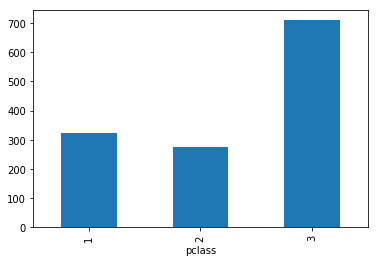

In [9]:
data.groupby('pclass').size().plot(kind='bar')

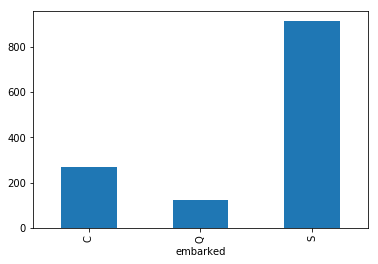

In [10]:
data.groupby('embarked').size().plot(kind='bar')

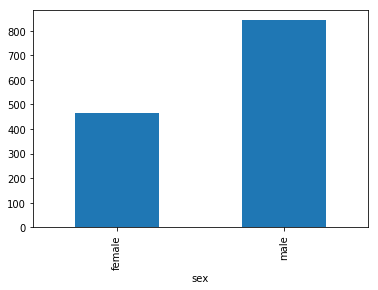

In [11]:
data.groupby('sex').size().plot(kind='bar')

here we separate age in decade interval wioth cut functions.

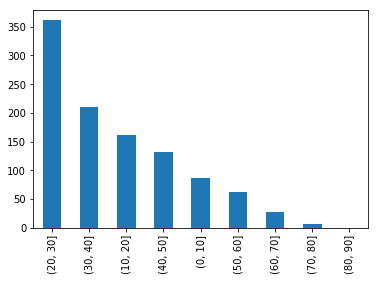

In [12]:
pd.cut(data['age'],bins  = 10 *np.arange(0,10)).value_counts().plot(kind='bar')


3)
===


C    31.864407
B    22.033898
D    15.593220
E    13.898305
A     7.457627
F     7.118644
G     1.694915
T     0.338983
Name: cabin, dtype: float64


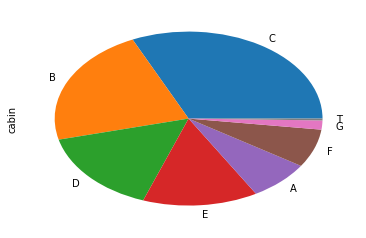

In [13]:
cabine = data['cabin']
# We remove pasenger without cabine and get first letter(levvel) 
cabinefloor = cabine[cabine.notnull()].str[0]
# We calculate the proportion with value_count/sum
proportion = cabinefloor.value_counts()/(cabinefloor.value_counts().sum())
print(proportion*100)
proportion.plot.pie()

4)
====

Group by for get passenger by pclass , and calculation survival proportion

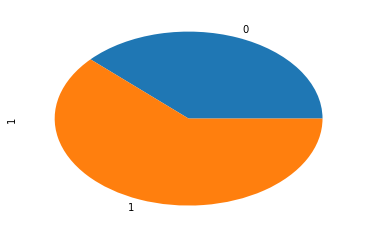

In [14]:
groupsuvived = data.groupby("pclass").apply( lambda x : x['survived'].value_counts(sort=False)/(x['survived'].value_counts().sum())  ) 
groupsuvived = groupsuvived.transpose()
#for i in range(1,4):
    #print(groupsuvived[i])
groupsuvived[1].plot.pie()



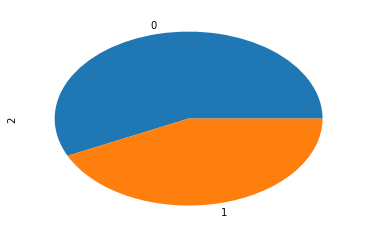

In [15]:
groupsuvived[2].plot.pie()

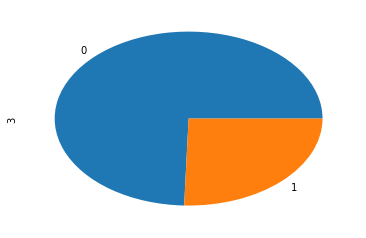

In [16]:
groupsuvived[3].plot.pie()

5)
===
Idem ,groub by pclass and sex , and proportion calculation

In [17]:
gbsexclass = data.groupby(["pclass","sex"])
gbsexclass = gbsexclass.apply( lambda x : x['survived'].value_counts(sort=False)/(x['survived'].value_counts().sum())  )
gbsexclass = gbsexclass.transpose()
gbsexclass = gbsexclass.drop(0)
gbsexclass

pclass           1                   2                   3         
sex         female      male    female      male    female     male
survived                                                           
1         0.965278  0.340782  0.886792  0.146199  0.490741  0.15213

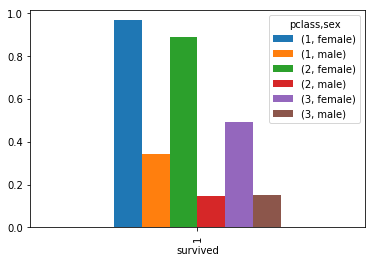

In [18]:
gbsexclass.plot(kind="bar")

6)
===
Idem , but we use decade interval

In [19]:
datawithcat =  data
datawithcat['age_cat'] =  pd.cut(data['age'],2)
datawithcat = data.groupby(["pclass","sex","age_cat"]).apply( lambda x : x['survived'].value_counts(sort=False)/(x['survived'].value_counts().sum())  )
datawithcat

survived                               0         1
pclass sex    age_cat                             
1      female (0.0869, 40.083]  0.036145  0.963855
              (40.083, 80.0]    0.040000  0.960000
       male   (0.0869, 40.083]  0.555556  0.444444
              (40.083, 80.0]    0.734177  0.265823
2      female (0.0869, 40.083]  0.091954  0.908046
              (40.083, 80.0]    0.187500  0.812500
       male   (0.0869, 40.083]  0.830645  0.169355
              (40.083, 80.0]    0.941176  0.058824
3      female (0.0869, 40.083]  0.514286  0.485714
              (40.083, 80.0]    0.666667  0.333333
       male   (0.0869, 40.083]  0.817891  0.182109
              (40.083, 80.0]    0.944444  0.055556

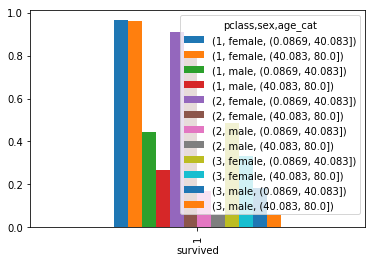

In [26]:
datawithcat.transpose().drop(0).plot(kind='bar')